# UVA SDS CAPSTONE

## EXTERNAL FETAL MONITORING; CLASSIFICATION OF FHR/UC PATTERNS

## Stephanie Verbout, Landon BLakey, Shashank Sharma, Hayley Kisiel

#### 28 April 2022

In [1]:
# library imports
import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_files 
from keras.utils import np_utils
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras import layers
import numpy as np

#!pip install tqdm
from tqdm import tqdm # progress bar


In [2]:
# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
GPU is NOT AVAILABLE


2022-04-25 14:03:37.421924: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-25 14:03:37.421971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-ba27-18): /proc/driver/nvidia/version does not exist


In [ ]:
# set up image directory and sizes
data_dir = "../common/images/"

In [3]:
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.35,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.35,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2398 files belonging to 5 classes.
Using 1559 files for training.
Found 2398 files belonging to 5 classes.
Using 839 files for validation.


2022-04-25 14:03:39.253591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# verify correct class names
train_ds.class_names

['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']

In [5]:
# function to split validation data into a validation and test dataset
#def create_test_data(dataset, mod: int):
#    val_batches = tf.data.experimental.cardinality(dataset)
#    test_dataset = dataset.take(val_batches // mod)
#    validation_dataset = dataset.skip(val_batches // mod)

#    print('Number of validation batches: %d' %    tf.data.experimental.cardinality(validation_dataset))
#    print('Number of validation files: %d' % (tf.data.experimental.cardinality(validation_dataset)*batch_size))
#    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
#    print('Number of test files: %d' % (tf.data.experimental.cardinality(test_dataset)*batch_size)) 

#    return test_dataset, validation_dataset

In [5]:
# function to split validation data into a validation and test dataset
mod = 5
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // mod)
validation_dataset = validation_ds.skip(val_batches // mod)

print('Number of validation_ds (val_batches) batches (validation batches + test batches): %d' % val_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation files: %d' % (tf.data.experimental.cardinality(validation_dataset)*val_batches))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of test files: %d' % (tf.data.experimental.cardinality(test_dataset)*val_batches)) 

Number of validation_ds (val_batches) batches (validation batches + test batches): 27
Number of validation batches: 22
Number of validation files: 594
Number of test batches: 5
Number of test files: 135


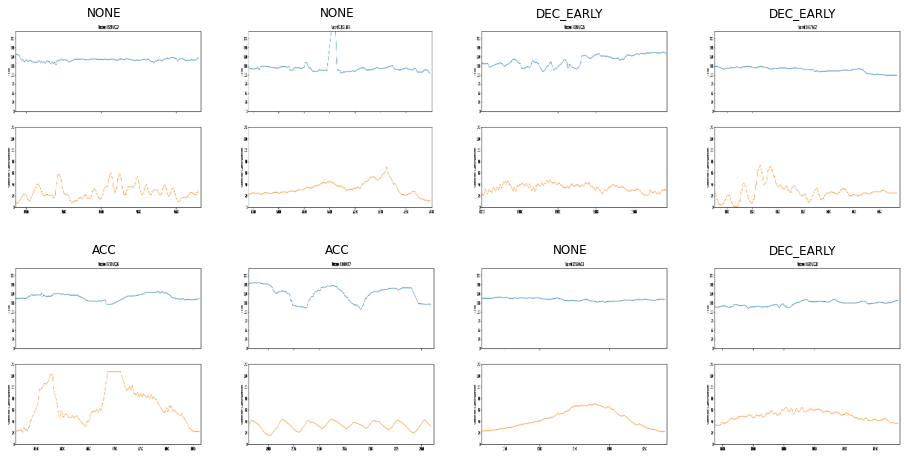

In [7]:
# display some example images
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']

NUM_CLASSES = len(class_names)

# Rows and columns are set to fit one training batch (32)
n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 4, n_rows * 4))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [23]:
# define a function to determine the number of each classification before splitting data
def get_class_counts(data):
    
    count_list = []
    for label_type in class_names:
        img_count = len(list(glob.glob(f"../common/images/{label_type}/record_*.png", recursive=True)))
        # append count to a list
        count_list.append(img_count)
    return count_list    # return the number of files for each class

In [25]:
#get_class_counts(train_ds)

In [102]:
# verify class names
class_names

['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']

In [8]:
# extract labels for each dataset
train_label = np.concatenate([y for x, y in train_ds], axis=0)
val_label = np.concatenate([y for x,y in validation_dataset], axis=0)
test_label = np.concatenate([y for x, y in test_dataset], axis=0)

In [9]:
# count instances of each class in each dataset
count_train = np.bincount(train_label).tolist()
count_val = np.bincount(val_label).tolist()
count_test = np.bincount(test_label).tolist()

In [10]:
# function to plot the distribution of each dataset
def plot_distributions(x_data, y_data, title, ylimit, color):
    # the freq of the data
    plt.rcParams["figure.figsize"] = (10,5)
    df = pd.DataFrame({'x_data':x_data,'y_data':y_data})
    df.sort_values('y_data', inplace=True)
    
    df.plot(kind='bar', y='y_data', x='x_data', color=color)
    plt.legend('')    #shows no legend
    plt.xlabel('Classification')
    plt.xticks(rotation = 45)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(0, ylimit)
    
    plt.show()

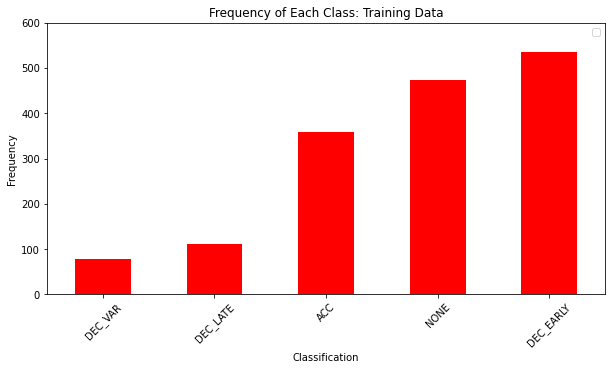

In [11]:
plot_distributions(class_names,count_train,'Frequency of Each Class: Training Data', 600, 'r')

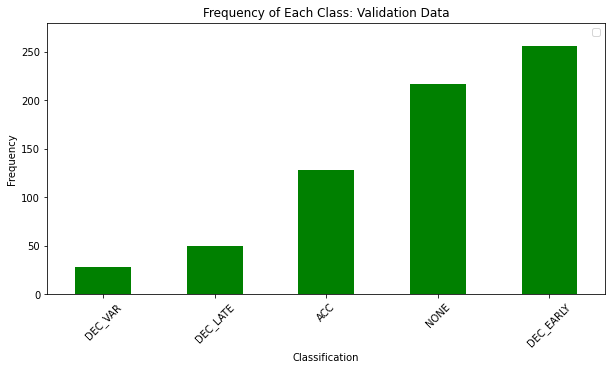

In [12]:
plot_distributions(class_names,count_val,'Frequency of Each Class: Validation Data', 280, 'g')

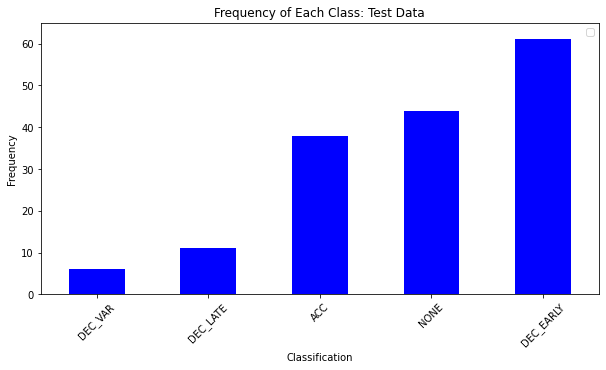

In [13]:
plot_distributions(class_names,count_test,'Frequency of Each Class: Test Data', 65, 'b')

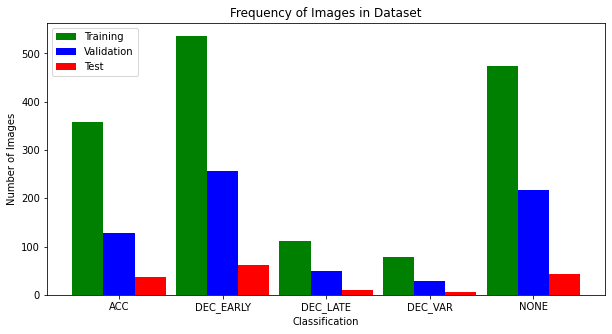

In [14]:
# plot grouped bar chart of all datasets
X_axis = np.arange(len(class_names))

width = 0.3
plt.bar(X_axis-width, count_train, 0.3, label = 'Training',color='g')
plt.bar(X_axis, count_val, 0.3, label = 'Validation',color='b')
plt.bar(X_axis+width, count_test, 0.3, label = 'Test',color='r')

plt.rcParams["figure.figsize"] = (10,8)
plt.xticks(X_axis, class_names)
plt.xlabel("Classification")
plt.ylabel("Number of Images")
plt.title("Frequency of Images in Dataset")
plt.legend()
plt.show()



In [36]:
# define function to plot the accuracies of train and validation set
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim(0.0,1.0)
    plt.show()

In [37]:
# Resets notebook state
tf.keras.backend.clear_session()

In [40]:
# build model function

def build_model(trainable_layers=15):

    #for layer in model.layers[ :-trainable_layers]:
    #    layer.trainable = False
    #for layer in model.layers[-trainable_layers: ]:
    #    layer.trainable = True

    model = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[299,299,3],   # our input_shape=[299, 299, 3]
                                    dtype='float32',
                                    input_tensor=None,
                                    sparse=False,
                                    name='input_1',
                                    ragged=None,
                                    type_spec=None),
            keras.layers.Conv2D(filters=4,                        # batch_input_shape = [1, 2, 1800]
                                kernel_size=(1,30),
                                strides=(1, 1),
                                padding='same',
                                data_format='channels_last',
                                dilation_rate=(1, 1),
                                groups=1,
                                activation='linear',
                                use_bias=False,
                                kernel_initializer='he_normal',
                                bias_initializer='zeros',
                                kernel_regularizer=None,
                                bias_regularizer=None,
                                activity_regularizer=None,
                                kernel_constraint=None,
                                bias_constraint=None,
                                trainable=True,
                                name='conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,scale=True,
                                            trainable=True,
                                            name='batch_normalization'),
            keras.layers.DepthwiseConv2D(kernel_size = (2, 1),
                                         strides=(1, 1),
                                         padding='valid',
                                         depth_multiplier=2,
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         depthwise_regularizer=None,
                                         bias_regularizer=None,
                                         activity_regularizer=None,
                                         depthwise_constraint="MaxNorm",
                                         bias_constraint=None,
                                         trainable=True,
                                         name='depthwise_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_1'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout'),
            keras.layers.SeparableConv2D(filters=8,
                                         kernel_size=(1,7),
                                         strides=(1, 1),
                                         padding='same',
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         depth_multiplier=1,
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         pointwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         trainable=True,
                                         name='separable_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_2'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation_1'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d_1'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout_1'),
            keras.layers.Flatten(data_format='channels_last', 
                                 trainable=True, 
                                 name='flatten'),
            keras.layers.Dense(units=NUM_CLASSES*150,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense1'),
            keras.layers.Dense(units=NUM_CLASSES*75,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense2'),
            keras.layers.Dense(units=NUM_CLASSES,
                               activation='softmax',
                               trainable=True,
                               name='softmax_output')   # we need
            ])

    optimizer = keras.optimizers.Adam(learning_rate=1e-5, decay=1e-3)
    # use sparse_categorical_crossentropy as labels are not one-hot encoded
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['sparse_categorical_accuracy'])

    print(model.summary())
    
    return model

In [41]:
# build the model with function above
model = build_model()
model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 4)       360       
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 4)      16        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 298, 299, 8)      16        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 298, 299, 8)      32        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 298, 299, 8)       0         
                                                      

Epoch 1/100


2022-04-24 19:54:39.743437: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-24 19:54:44.717175: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - 17s 167ms/step - loss: 27.0774 - sparse_categorical_accuracy: 0.2790 - val_loss: 30.4325 - val_sparse_categorical_accuracy: 0.0471
Epoch 2/100
49/49 [==============================] - 8s 163ms/step - loss: 26.0321 - sparse_categorical_accuracy: 0.3361 - val_loss: 29.0148 - val_sparse_categorical_accuracy: 0.1649
Epoch 3/100
49/49 [==============================] - 8s 163ms/step - loss: 25.8359 - sparse_categorical_accuracy: 0.3509 - val_loss: 28.6490 - val_sparse_categorical_accuracy: 0.3240
Epoch 4/100
49/49 [==============================] - 8s 163ms/step - loss: 25.7074 - sparse_categorical_accuracy: 0.3740 - val_loss: 27.7607 - val_sparse_categorical_accuracy: 0.3373
Epoch 5/100
49/49 [==============================] - 8s 164ms/step - loss: 25.3300 - sparse_categorical_accuracy: 0.3932 - val_loss: 26.5998 - val_sparse_categorical_accuracy: 0.3137
Epoch 6/100
49/49 [==============================] - 8s 161ms/step - loss: 25.5043 - sparse_cate

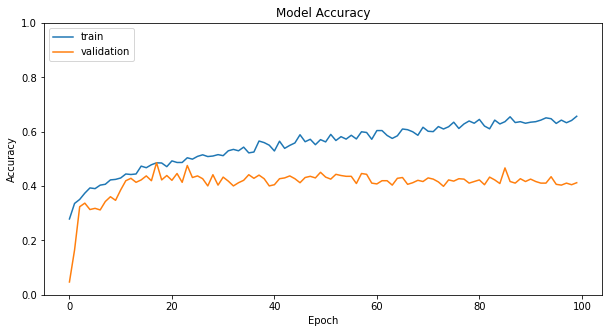

In [42]:
# fit the model to image data and train
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=validation_dataset,
                    batch_size = batch_size,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                    )
# plot the accuracies and epochs
plot_hist(history)

In [22]:
# evaluate model on test_dataset
model.evaluate(test_dataset)

3/3 [==============================] - 0s 19ms/step - loss: 8.7907 - sparse_categorical_accuracy: 0.4271


[8.790680885314941, 0.4270833432674408]

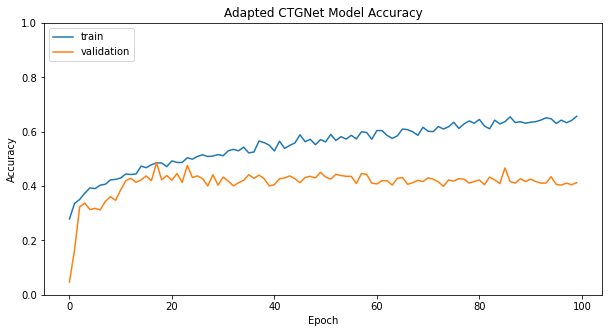

In [43]:
# define function to plot the accuracies of train and validation set
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Adapted CTGNet Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim(0.0,1.0)
    plt.show()
    
plot_hist(history)

In [23]:
# save model
model.save('CTG_model_final')

2022-04-23 19:33:31.086817: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CTG_model_final/assets


In [24]:
# see labels in test_dataset
#for image, label in test_dataset.take(5):
#    print (label)

In [44]:
# concatenate test labels with test predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, (y.numpy())])

In [45]:
# show confusion matrix
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[ 3,  4,  0,  2, 26],
       [ 6, 28,  0,  2, 23],
       [ 1,  5,  1,  2,  3],
       [ 1,  3,  0,  1,  2],
       [ 0,  9,  1,  3, 34]], dtype=int32)

In [46]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.27      0.09      0.13        35
         1.0       0.57      0.47      0.52        59
         2.0       0.50      0.08      0.14        12
         3.0       0.10      0.14      0.12         7
         4.0       0.39      0.72      0.50        47

    accuracy                           0.42       160
   macro avg       0.37      0.30      0.28       160
weighted avg       0.43      0.42      0.38       160



In [47]:
# to make confusion matrix easier
y_true = labels.tolist()
y_pred = predictions.tolist()

Confusion matrix:
[[ 3  4  0  2 26]
 [ 6 28  0  2 23]
 [ 1  5  1  2  3]
 [ 1  3  0  1  2]
 [ 0  9  1  3 34]]


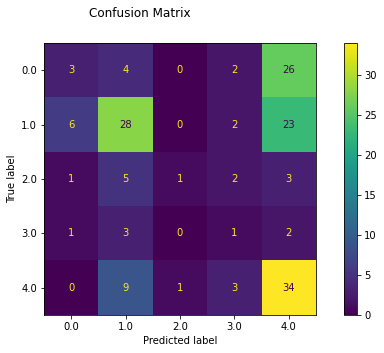

In [48]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

## Now apply transfer learning

In [66]:
# now apply transfer learning
def build_model_transfer(model_base, img_size=None, trainable_layers=15):

    for layer in model_base.layers[ :-trainable_layers]:
      layer.trainable = False
    for layer in model_base.layers[-trainable_layers: ]:
      layer.trainable = True
    
    
    model = keras.Sequential()
    model.add(keras.layers.Lambda(lambda image: tf.image.resize(image, (img_size, img_size))))
    # model.add(keras.layers.RandomFlip("horizontal"))
    # model.add(keras.layers.RandomRotation(0.1))
    # model.add(keras.layers.Rescaling(scale=1 / 127.5, offset=-1))
    model.add(model_base)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='elu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(NUM_CLASSES, activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3)

    model.build(input_shape=(None,299,299,3))
    # use sparse_categorical_crossentropy as labels are not one-hot encoded
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    print(model.summary())
    
    return model

In [67]:
# create base EfficientNet model with ImageNet images
base_model1 = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=(299,299,3), weights="imagenet")

# build the model
model_1 = build_model_transfer(base_model1, img_size=299, trainable_layers=118)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 299, 299, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

In [65]:
#base_model1.summary()

In [68]:
# fit the model to training data and validation data
history_eff = model_1.fit(train_ds,
                      epochs=80,
                      validation_data = validation_dataset,
                      batch_size = batch_size,
                      callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                      )

Epoch 1/80
49/49 [==============================] - 15s 149ms/step - loss: 2.6366 - accuracy: 0.2457 - val_loss: 1.6097 - val_accuracy: 0.3535
Epoch 2/80
49/49 [==============================] - 5s 97ms/step - loss: 2.1293 - accuracy: 0.3573 - val_loss: 1.5718 - val_accuracy: 0.3373
Epoch 3/80
49/49 [==============================] - 5s 97ms/step - loss: 1.9811 - accuracy: 0.4080 - val_loss: 1.5580 - val_accuracy: 0.3211
Epoch 4/80
49/49 [==============================] - 5s 99ms/step - loss: 1.7649 - accuracy: 0.4394 - val_loss: 1.4429 - val_accuracy: 0.4433
Epoch 5/80
49/49 [==============================] - 5s 101ms/step - loss: 1.5963 - accuracy: 0.4779 - val_loss: 1.4517 - val_accuracy: 0.4404
Epoch 6/80
49/49 [==============================] - 5s 94ms/step - loss: 1.5650 - accuracy: 0.4978 - val_loss: 1.4910 - val_accuracy: 0.4595
Epoch 7/80
49/49 [==============================] - 5s 98ms/step - loss: 1.3723 - accuracy: 0.5625 - val_loss: 1.6072 - val_accuracy: 0.4786
Epoch 8/80

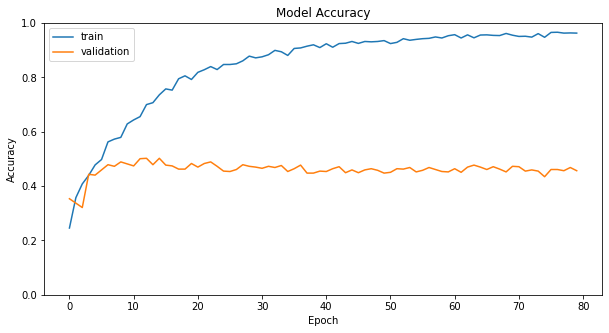

In [69]:
# define function to plot the accuracies of train and validation set
def plot_hist_transfer(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim(0.0,1.0)
    plt.show()

# plot the accuracy curves
plot_hist_transfer(history_eff)

In [70]:
# evaluate model on test_dataset
model_1.evaluate(test_dataset)

5/5 [==============================] - 1s 56ms/step - loss: 3.4426 - accuracy: 0.4375


[3.4425976276397705, 0.4375]

In [35]:
# save model
model_1.save('CTG_model_final_EFF')

INFO:tensorflow:Assets written to: CTG_model_final_EFF/assets


In [71]:
# concatenate test labels with test predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model_1.predict(x), axis=-1)])
  labels = np.concatenate([labels, (y.numpy())])

In [72]:
# show confusion matrix
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[16,  8,  3,  0, 11],
       [14, 30,  2,  4, 11],
       [ 2,  3,  3,  0,  2],
       [ 1,  1,  2,  1,  3],
       [ 7, 13,  0,  1, 22]], dtype=int32)

In [73]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.40      0.42      0.41        38
         1.0       0.55      0.49      0.52        61
         2.0       0.30      0.30      0.30        10
         3.0       0.17      0.12      0.14         8
         4.0       0.45      0.51      0.48        43

    accuracy                           0.45       160
   macro avg       0.37      0.37      0.37       160
weighted avg       0.45      0.45      0.45       160



In [74]:
# to make confusion matrix easier
y_true = labels.tolist()
y_pred = predictions.tolist()

Confusion matrix:
[[16  8  3  0 11]
 [14 30  2  4 11]
 [ 2  3  3  0  2]
 [ 1  1  2  1  3]
 [ 7 13  0  1 22]]


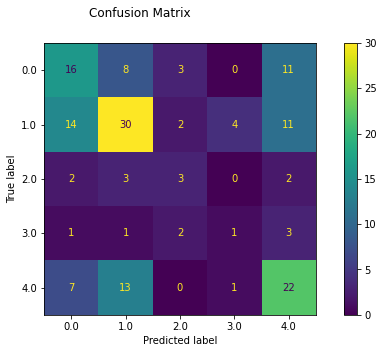

In [75]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [76]:
# create base Xception model with ImageNet images
base_model2 = tf.keras.applications.xception.Xception(include_top=False, input_shape=(299,299,3), weights="imagenet")

# build the model
model_2 = build_model_transfer(base_model2, img_size=299, trainable_layers=50)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)             

Epoch 1/80
49/49 [==============================] - 8s 103ms/step - loss: 2.4190 - accuracy: 0.2861 - val_loss: 1.6371 - val_accuracy: 0.1679
Epoch 2/80
49/49 [==============================] - 4s 83ms/step - loss: 2.1983 - accuracy: 0.3406 - val_loss: 1.5347 - val_accuracy: 0.4345
Epoch 3/80
49/49 [==============================] - 4s 86ms/step - loss: 2.0327 - accuracy: 0.3586 - val_loss: 1.5118 - val_accuracy: 0.4286
Epoch 4/80
49/49 [==============================] - 4s 87ms/step - loss: 1.9419 - accuracy: 0.4015 - val_loss: 1.4450 - val_accuracy: 0.4433
Epoch 5/80
49/49 [==============================] - 4s 85ms/step - loss: 1.7948 - accuracy: 0.4150 - val_loss: 1.4293 - val_accuracy: 0.4286
Epoch 6/80
49/49 [==============================] - 4s 85ms/step - loss: 1.7266 - accuracy: 0.4285 - val_loss: 1.4208 - val_accuracy: 0.4418
Epoch 7/80
49/49 [==============================] - 4s 86ms/step - loss: 1.6410 - accuracy: 0.4682 - val_loss: 1.4207 - val_accuracy: 0.4595
Epoch 8/80
4

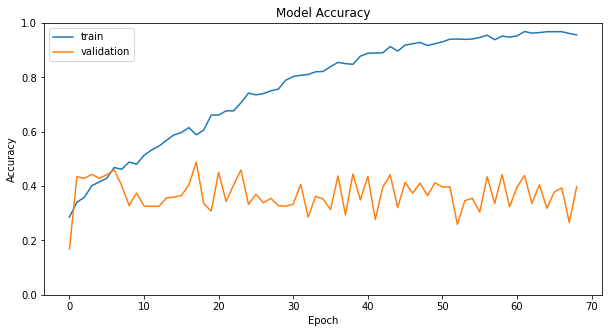

In [77]:
history_Xception = model_2.fit(train_ds,
                      epochs=80,
                      validation_data = validation_dataset,
                      batch_size = batch_size,
                      callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                      )

plot_hist_transfer(history_Xception)

In [78]:
# evaluate model on test_dataset
model_2.evaluate(test_dataset)

5/5 [==============================] - 0s 49ms/step - loss: 3.5357 - accuracy: 0.3938


[3.535727024078369, 0.39375001192092896]

In [44]:
# save model
model_2.save('CTG_model_final_Xception')

INFO:tensorflow:Assets written to: CTG_model_final_Xception/assets


In [79]:
# concatenate test labels with test predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model_2.predict(x), axis=-1)])
  labels = np.concatenate([labels, (y.numpy())])
    
# show confusion matrix
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[25,  4,  0,  2,  5],
       [23, 26,  1,  3,  9],
       [ 2,  1,  1,  0,  4],
       [ 2,  2,  1,  0,  0],
       [18, 12,  0,  4, 15]], dtype=int32)

In [80]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.36      0.69      0.47        36
         1.0       0.58      0.42      0.49        62
         2.0       0.33      0.12      0.18         8
         3.0       0.00      0.00      0.00         5
         4.0       0.45      0.31      0.37        49

    accuracy                           0.42       160
   macro avg       0.34      0.31      0.30       160
weighted avg       0.46      0.42      0.42       160



Confusion matrix:
[[25  4  0  2  5]
 [23 26  1  3  9]
 [ 2  1  1  0  4]
 [ 2  2  1  0  0]
 [18 12  0  4 15]]


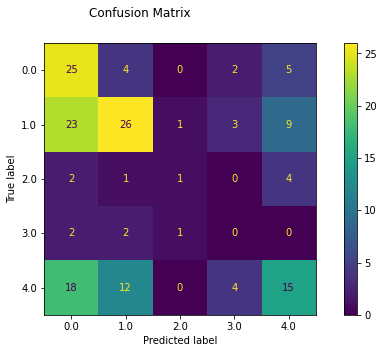

In [81]:
# to make confusion matrix easier
y_true = labels.tolist()
y_pred = predictions.tolist()
# show heat map confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [48]:
# create base NasNet model with ImageNet images
base_model3 = tf.keras.applications.NASNetMobile(include_top=False, input_shape=(224,224,3), weights="imagenet")

# build the model
model_3 = build_model_transfer(base_model3, img_size=224, trainable_layers=30)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_2   (None, 1056)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 1056)             4224      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1056)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

Epoch 1/100
61/61 [==============================] - 17s 119ms/step - loss: 2.6086 - accuracy: 0.2356 - val_loss: 1.9478 - val_accuracy: 0.1722
Epoch 2/100
61/61 [==============================] - 3s 45ms/step - loss: 2.4550 - accuracy: 0.2732 - val_loss: 1.8627 - val_accuracy: 0.1877
Epoch 3/100
61/61 [==============================] - 3s 46ms/step - loss: 2.4010 - accuracy: 0.2845 - val_loss: 1.8528 - val_accuracy: 0.2211
Epoch 4/100
61/61 [==============================] - 3s 45ms/step - loss: 2.3186 - accuracy: 0.2814 - val_loss: 2.1165 - val_accuracy: 0.2776
Epoch 5/100
61/61 [==============================] - 3s 45ms/step - loss: 2.2511 - accuracy: 0.2851 - val_loss: 3.0633 - val_accuracy: 0.1825
Epoch 6/100
61/61 [==============================] - 3s 44ms/step - loss: 2.2307 - accuracy: 0.3021 - val_loss: 2.7954 - val_accuracy: 0.2725
Epoch 7/100
61/61 [==============================] - 3s 46ms/step - loss: 2.0974 - accuracy: 0.3232 - val_loss: 3.4561 - val_accuracy: 0.2134
Epoc

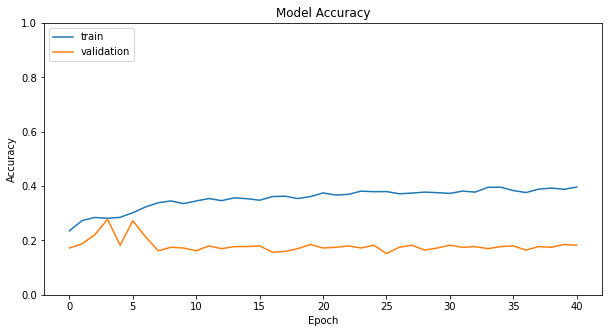

In [49]:
history_NASNet = model_3.fit(train_ds,
                      epochs=100,
                      validation_data = validation_dataset,
                      batch_size = batch_size,
                      callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                      )

plot_hist_transfer(history_NASNet)

In [50]:
# evaluate model on test_dataset
model_3.evaluate(test_dataset)

3/3 [==============================] - 0s 33ms/step - loss: 6.1852 - accuracy: 0.1354


[6.185157299041748, 0.1354166716337204]

In [51]:
# save model
model_3.save('CTG_model_final_NASNet')

INFO:tensorflow:Assets written to: CTG_model_final_NASNet/assets


In [52]:
# concatenate test labels with test predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model_3.predict(x), axis=-1)])
  labels = np.concatenate([labels, (y.numpy())])
    
# show confusion matrix
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[14,  0,  0,  0,  0,  0],
       [36,  0,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  0],
       [34,  0,  0,  0,  0,  0]], dtype=int32)

In [53]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.15      1.00      0.25        14
         1.0       0.00      0.00      0.00        36
         2.0       0.00      0.00      0.00         8
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00        34

    accuracy                           0.15        96
   macro avg       0.03      0.20      0.05        96
weighted avg       0.02      0.15      0.04        96



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[14  0  0  0  0]
 [36  0  0  0  0]
 [ 8  0  0  0  0]
 [ 4  0  0  0  0]
 [34  0  0  0  0]]


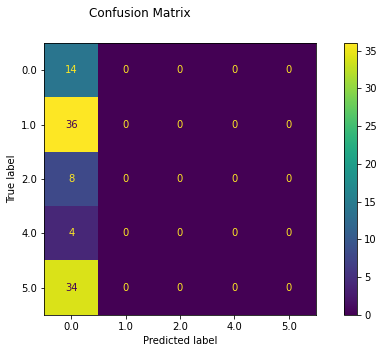

In [54]:
# to make confusion matrix easier
y_true = labels.tolist()
y_pred = predictions.tolist()
# show heat map confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [55]:
# create base VGG16 model with ImageNet images
base_model4 = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3), weights="imagenet")

# build the model
model_4 = build_model_transfer(base_model4, img_size=224, trainable_layers=15)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

Epoch 1/100
61/61 [==============================] - 7s 85ms/step - loss: 2.6884 - accuracy: 0.2062 - val_loss: 28.4805 - val_accuracy: 0.3882
Epoch 2/100
61/61 [==============================] - 4s 64ms/step - loss: 2.3999 - accuracy: 0.2619 - val_loss: 9.7836 - val_accuracy: 0.3393
Epoch 3/100
61/61 [==============================] - 4s 63ms/step - loss: 2.1887 - accuracy: 0.2861 - val_loss: 38.8205 - val_accuracy: 0.0797
Epoch 4/100
61/61 [==============================] - 4s 67ms/step - loss: 2.0911 - accuracy: 0.3216 - val_loss: 10.2110 - val_accuracy: 0.0514
Epoch 5/100
61/61 [==============================] - 4s 65ms/step - loss: 2.0914 - accuracy: 0.3134 - val_loss: 16.6995 - val_accuracy: 0.0874
Epoch 6/100
61/61 [==============================] - 4s 63ms/step - loss: 2.0651 - accuracy: 0.3325 - val_loss: 21.3597 - val_accuracy: 0.0694
Epoch 7/100
61/61 [==============================] - 4s 65ms/step - loss: 2.0072 - accuracy: 0.3309 - val_loss: 9.7367 - val_accuracy: 0.0823
E

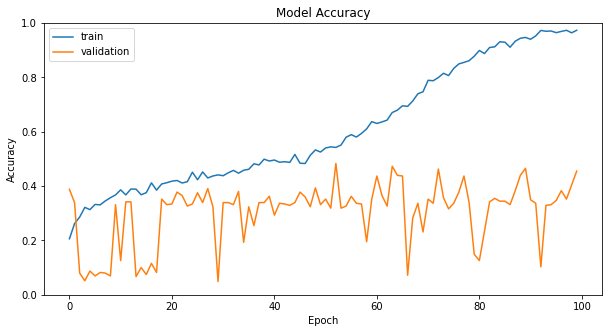

In [56]:
history_VGG16 = model_4.fit(train_ds,
                      epochs=100,
                      validation_data = validation_dataset,
                      batch_size = batch_size,
                      callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                      )

plot_hist_transfer(history_VGG16)

In [57]:
# evaluate model on test_dataset
model_4.evaluate(test_dataset)

3/3 [==============================] - 0s 36ms/step - loss: 7.1758 - accuracy: 0.4375


[7.175775051116943, 0.4375]

In [58]:
# save model
model_4.save('CTG_model_final_VGG16')

INFO:tensorflow:Assets written to: CTG_model_final_VGG16/assets


In [59]:
# concatenate test labels with test predictions
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model_4.predict(x), axis=-1)])
  labels = np.concatenate([labels, (y.numpy())])
    
# show confusion matrix
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[ 0, 12,  0,  0,  0,  3],
       [ 0, 29,  0,  0,  0,  5],
       [ 0,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0, 13]], dtype=int32)

In [60]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.39      0.85      0.53        34
         2.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         4
         5.0       0.62      0.33      0.43        39

    accuracy                           0.44        96
   macro avg       0.20      0.24      0.19        96
weighted avg       0.39      0.44      0.36        96



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[ 0 12  0  0  3]
 [ 0 29  0  0  5]
 [ 0  4  0  0  0]
 [ 0  4  0  0  0]
 [ 0 26  0  0 13]]


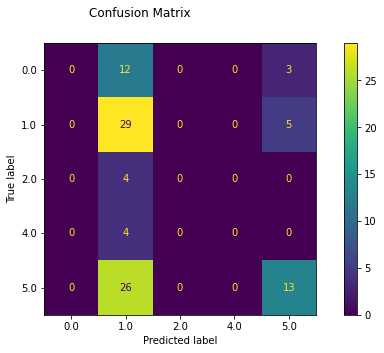

In [61]:
# to make confusion matrix easier
y_true = labels.tolist()
y_pred = predictions.tolist()
# show heat map confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()